In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir(os.path.expanduser("/notebooks/segmentation"))

import numpy as np

from train_utils.utils import Dice, mIoU, Lion # pylint: disable=unused-import
from train_utils.unet_pipeline_trainer import train
from plotter.plot import plot_prediction

from PIL import Image

from batchflow.batchflow import B, V, Pipeline
from batchflow.batchflow.models.torch.unet import UNet as Unet_bf
from batchflow.batchflow.opensets import PascalSegmentation
from batchflow.batchflow.plotter.plot import plot

In [3]:
train_params = {
    'BATCH_SIZE': 96,
    'LR': 1e-4,
    'NUM_CLASSES': 21,
    'NUM_EPOCHS': 90,
    'IMAGE_SHAPE': (256, 256)
}

In [4]:
ds = PascalSegmentation()
ds.split([0.7, 0.2, 0.1], shuffle=False)

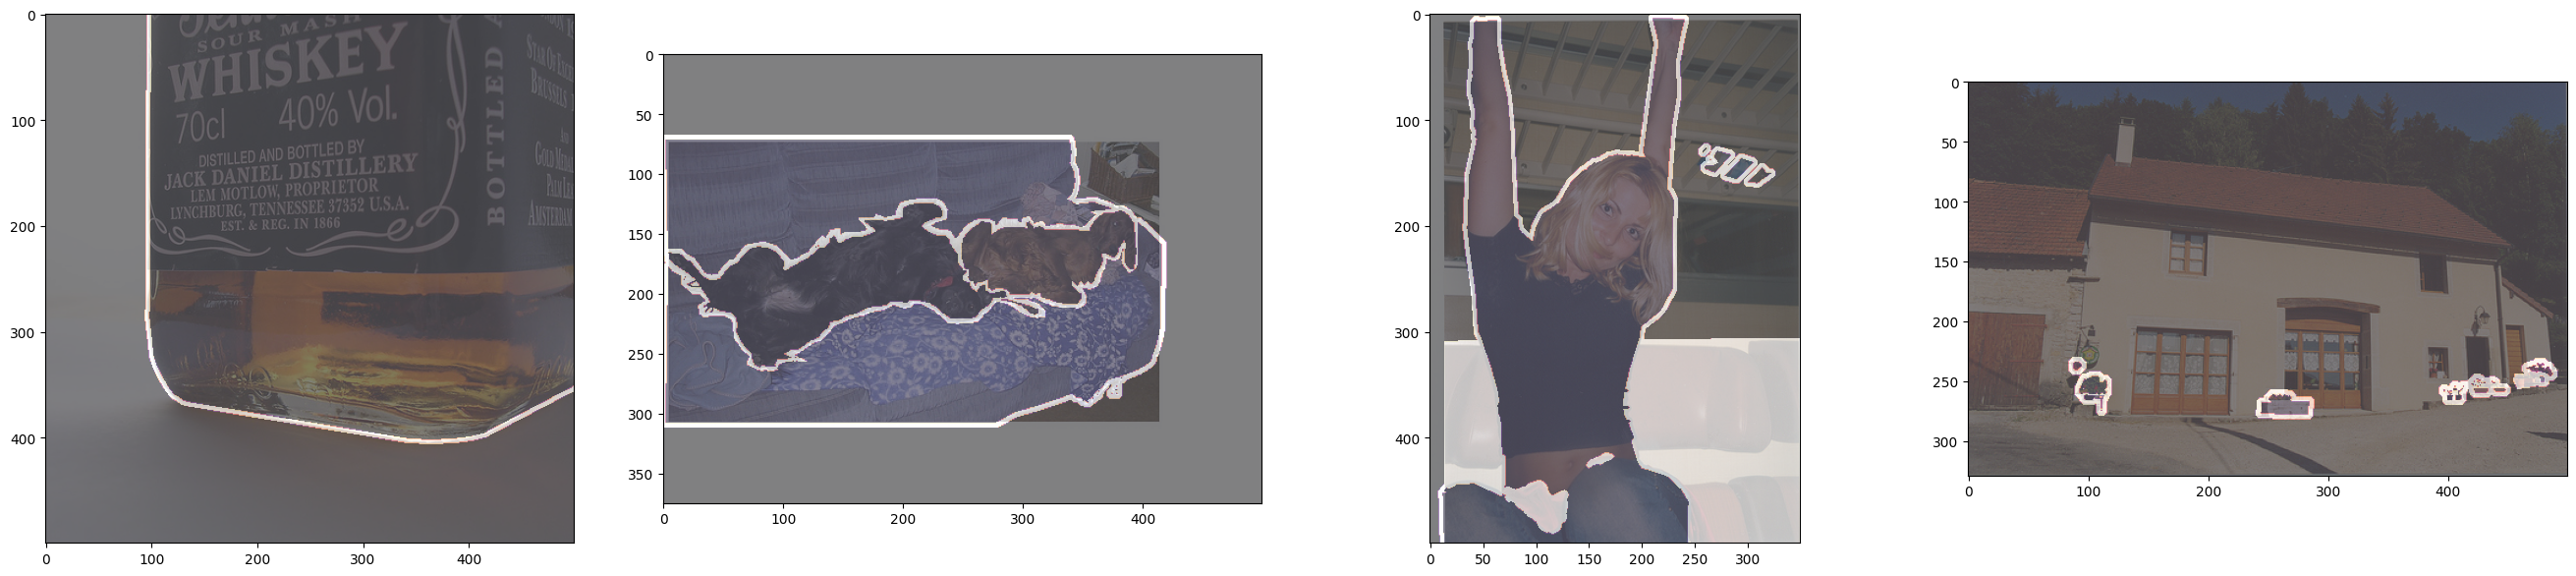

In [5]:
plot(
    data=[[np.array(ds.images[-1]), np.array(ds.labels[-1])], 
          [np.array(ds.images[-2]), np.array(ds.labels[-2])], 
          [np.array(ds.images[-3]), np.array(ds.labels[-3])],
          [np.array(ds.images[-4]), np.array(ds.labels[-4])]],
    cmap='batchflow',
    alpha=0.5
)

In [16]:
config = Unet_bf.default_config()
config['decay'] = {'name': 'cos', 'T_max': 8000, 'frequency': 2000}

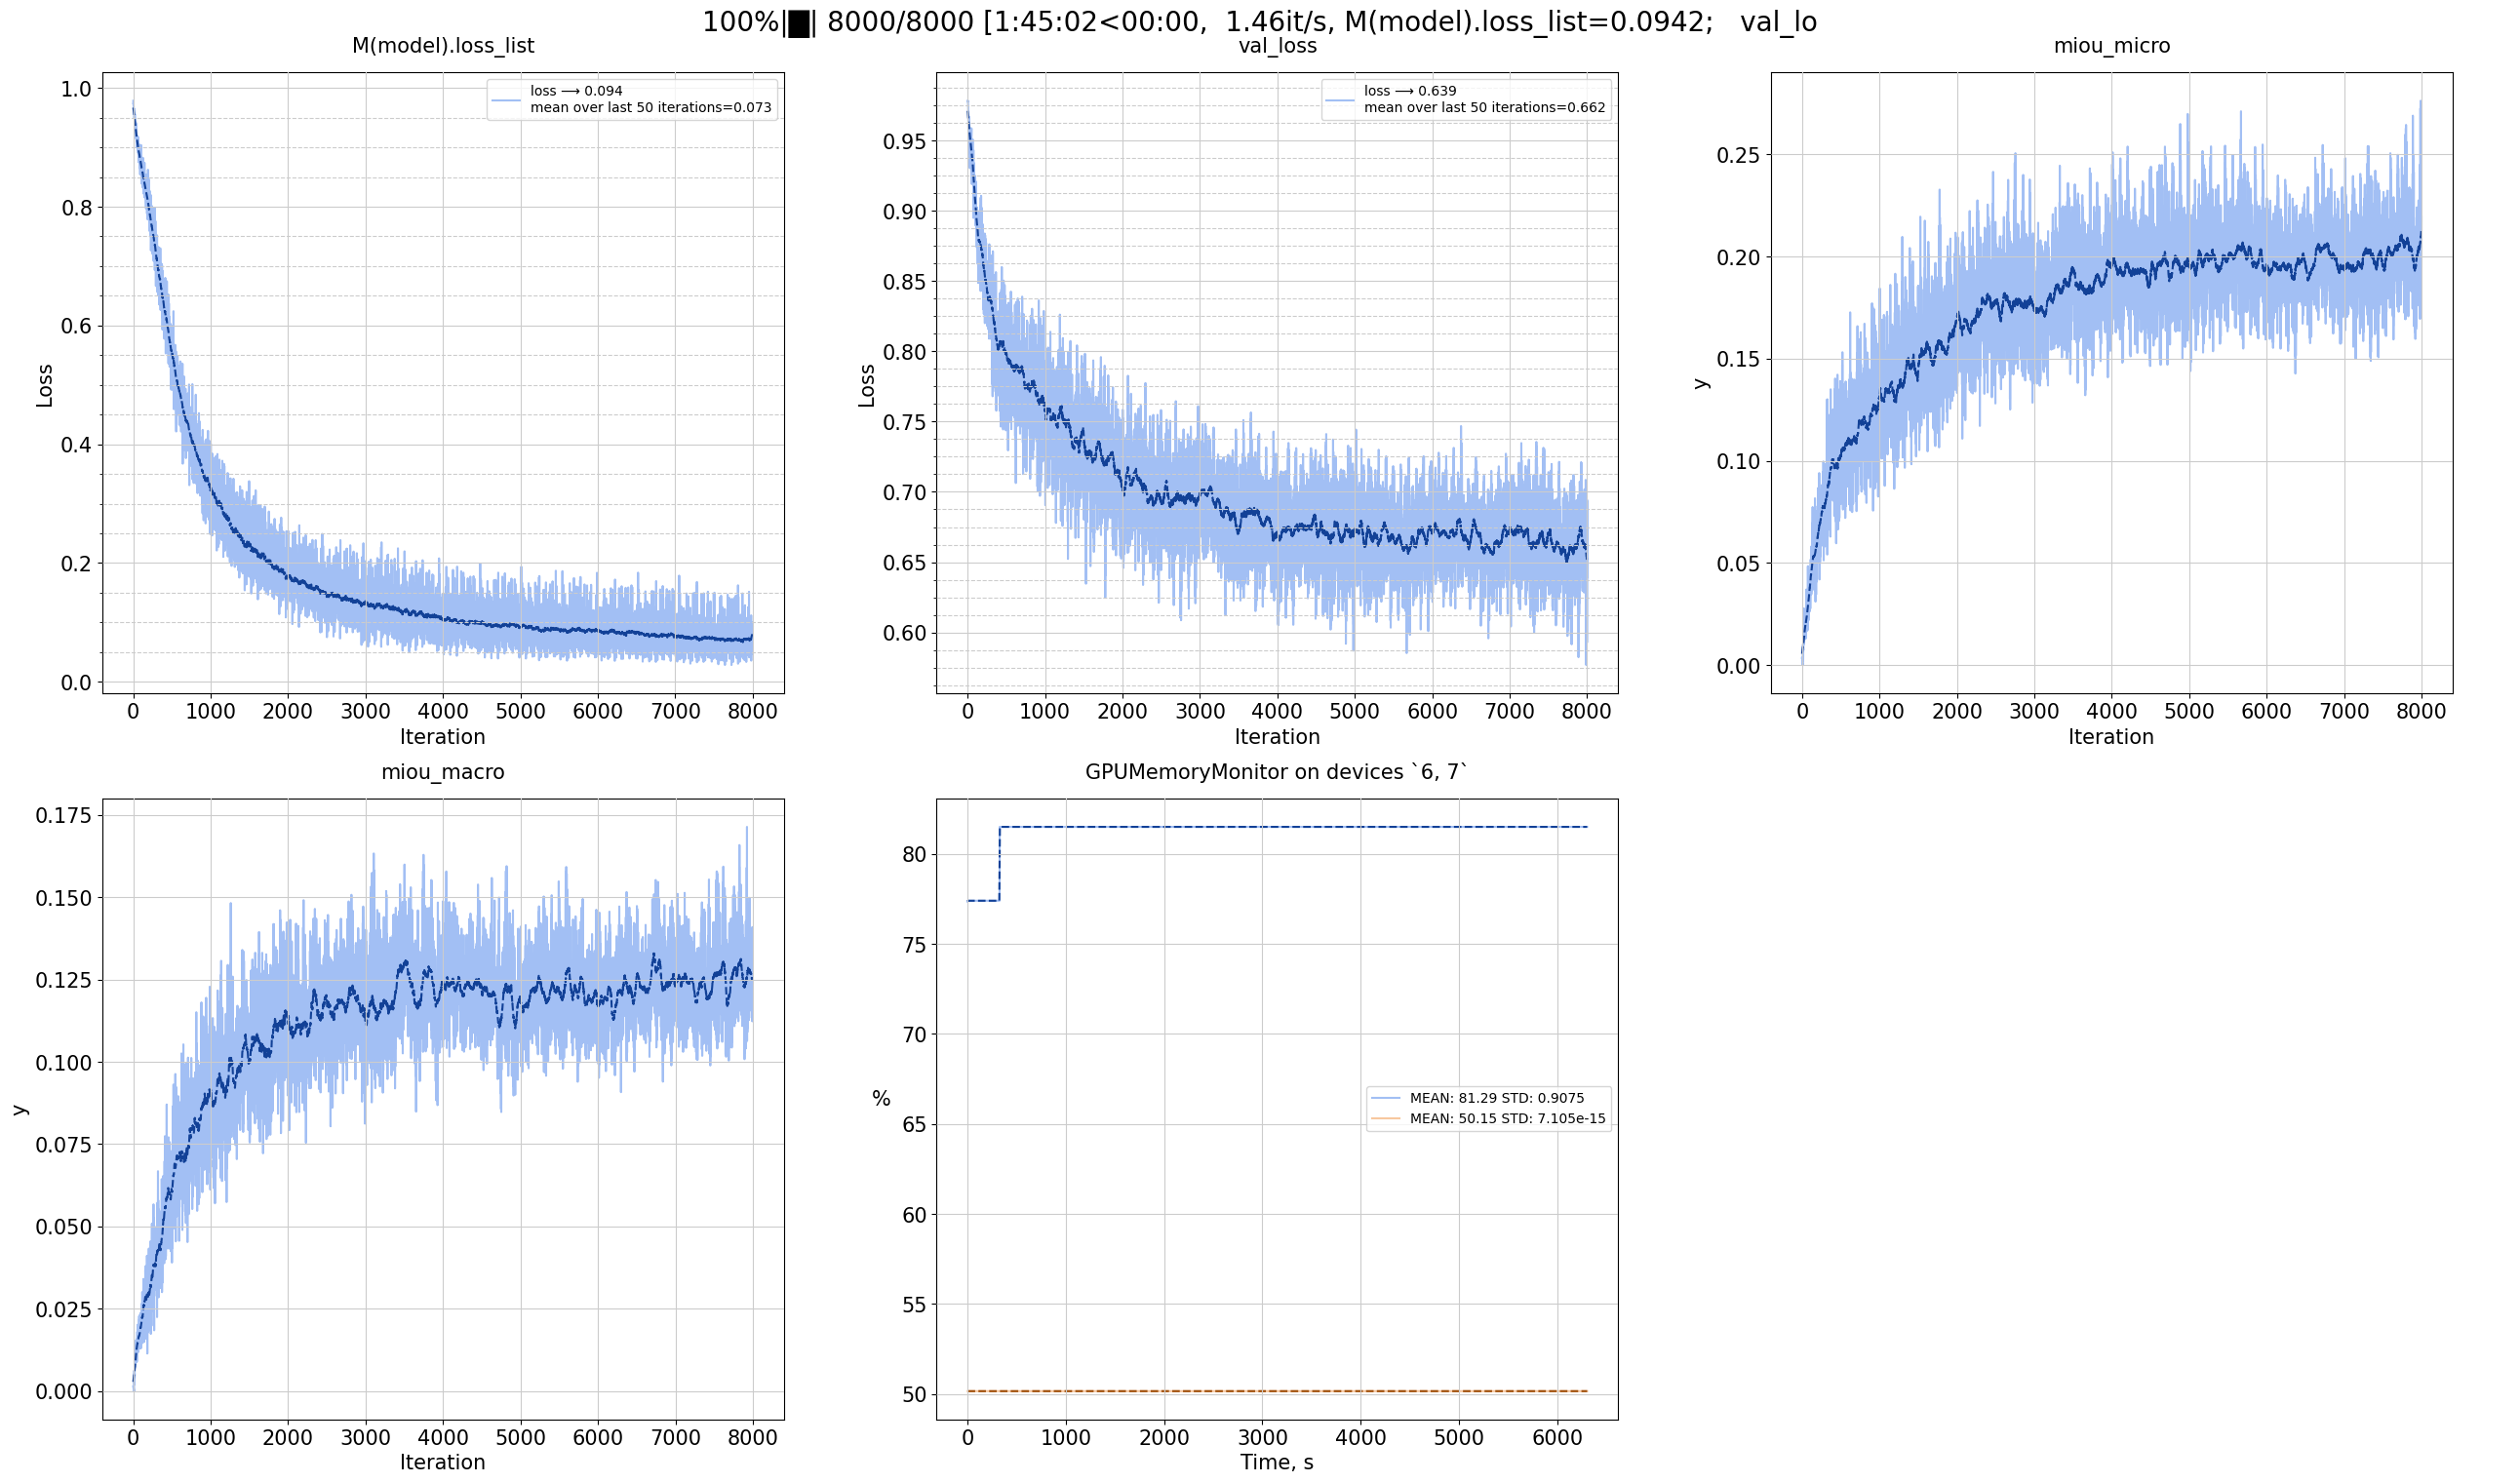

In [17]:
train_pipeline, val_pipeline = train(
    dataset=ds,
    config=config,
    loss=Dice, 
    optimizer={'name': Lion, 'lr': train_params['LR']},
    train_params=train_params,
    n_iters=8000,
    visible_devices='6,7',
    frequency=100
)

In [18]:
test_pipeline = (
    Pipeline()
    .import_model('model', train_pipeline)
    .init_variable('images', [])
    .init_variable('predictions', [])
    .init_variable('masks', [])
    .init_variable('iou', [])

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.BILINEAR, src='images', dst='images')
    .to_array(channels='first', dtype=np.float32, src='images', dst='images')

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.NEAREST, src='labels', dst='masks')
    .to_array(channels='first', dtype=np.int64, src='masks', dst='masks')

    .predict_model('model', inputs=B.images,
                   outputs='predictions', save_to=V('predictions', mode='a'))
    .update(V('images', mode='a'), B.images)
    .update(V('masks', mode='a'), B.masks)
    .mIoU(preds=V.predictions[-1], mask=B('masks'), num_classes=train_params['NUM_CLASSES'], save_to=V('iou', mode='a'))
) << ds.test

test_pipeline = test_pipeline.run(batch_size=1, shuffle=False, n_epochs=1, drop_last=False, bar=True)

  0%|                                                                                                         …

In [19]:
np.mean(test_pipeline.v('iou'))

0.12730591

# Results

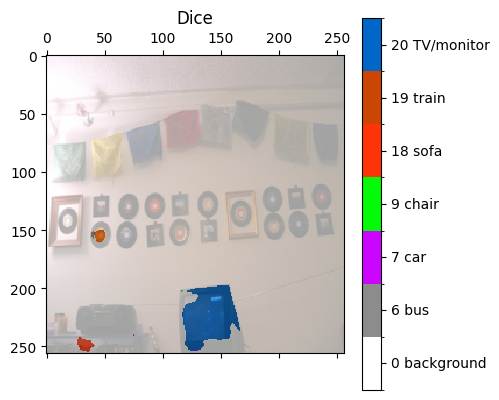

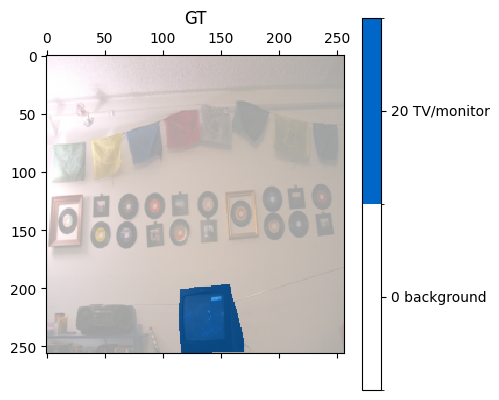

In [20]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=0, dataset='pascal', title='Dice')

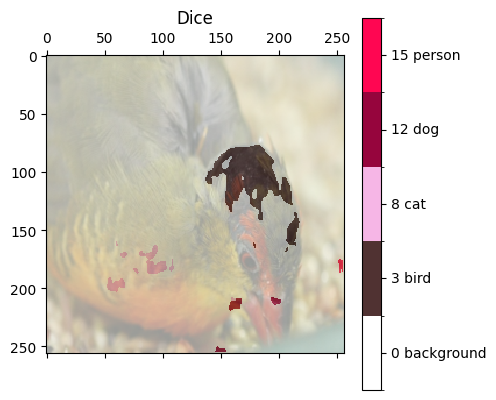

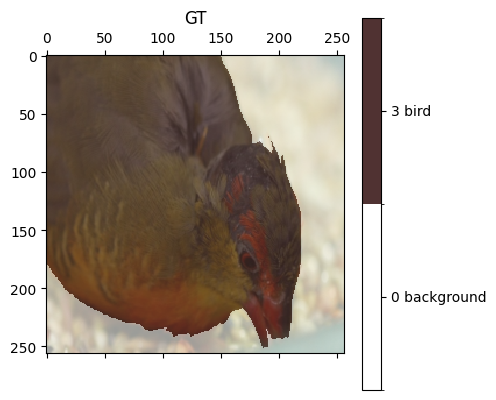

In [21]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=10, dataset='pascal', title='Dice')

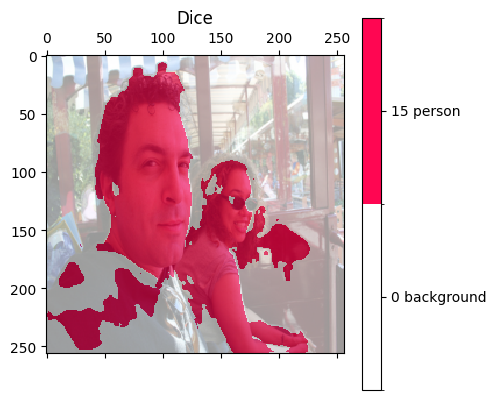

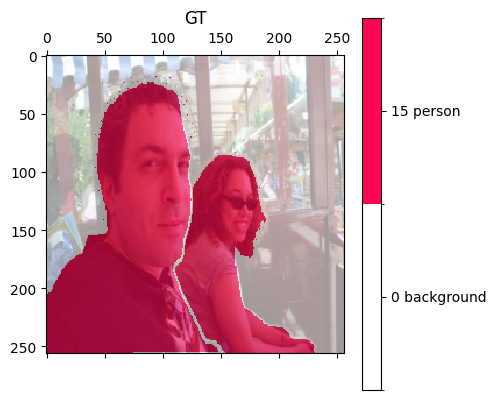

In [22]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=100, dataset='pascal', title='Dice')

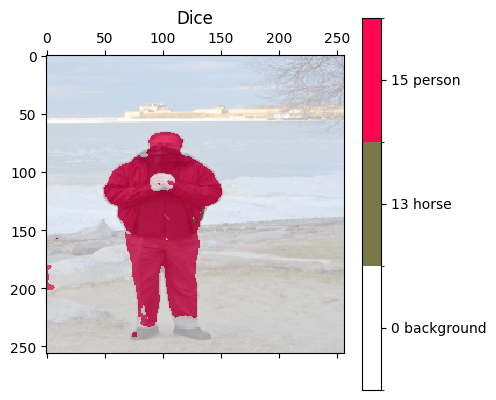

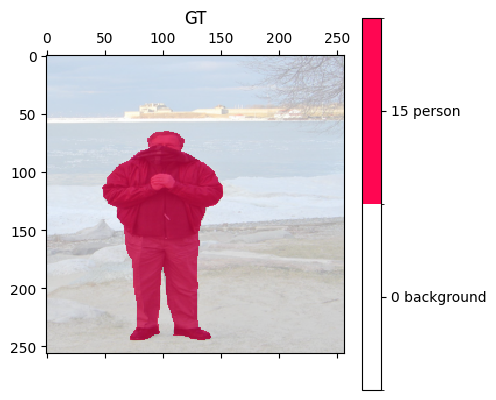

In [23]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=150, dataset='pascal', title='Dice')

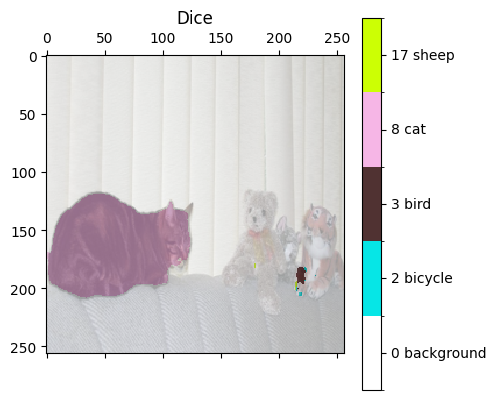

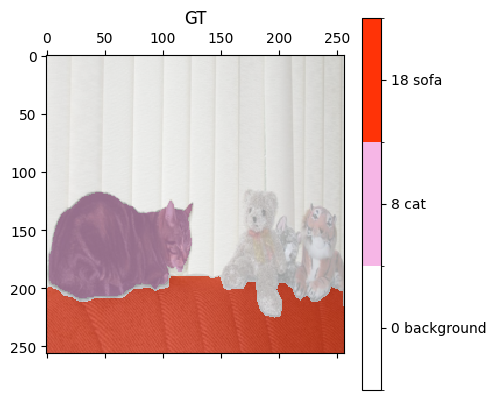

In [24]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=200, dataset='pascal', title='Dice')

In [1]:
from nbtools import pylint_notebook
pylint_notebook()

Your code has been rated at 10.00/10
––––––––––––––––––––––––––––––––––––
